# Biweekly Report 3 - Part I: EDA and limitations of LSTM on an Imbalanced Dataset.
## Allison Liu

In my previous report, I explored the Transformer model an attention-based network architecture often used for neural machine translation. The attention mechanism of Transformer can be applied to gather information about context of a given word. In this biweekly report, I am interested in implementing BERT (Bidirectional Encoder Representations from Transformers), a variant of the Transformer, and using it to solve an intent classification problem.

BERT is a trained Transformer Encoder stack, with 12 layers (in the Base version), compared to 6 in the original Transformer model.

In this notebook, I do some EDA on an imbalanced dataset which has user inputs of flight search queries and labels describing the intent of the user (flight, airfare, ground service, etc). Because I am interested in solving an intent classification problem, I also briefly analyze the results of a report done using a simple LSTM on the same dataset and compare to BERT, which should supposedly do better.

This notebook is based off a tutorial found here: https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03

## EDA
I will be using the Airline Travel Information System (ATIS) dataset found here: https://www.kaggle.com/siddhadev/atis-dataset-from-ms-cntk.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [2]:
DATA_DIR = './data'

# load Pickle file 
def load_ds(fname=os.path.join(DATA_DIR,'/atis.train.pkl'), verbose=True):
    with open(fname, 'rb') as stream:
        ds,dicts = pickle.load(stream)
    if verbose:
      print('Done  loading: ', fname)
      print('      samples: {:4d}'.format(len(ds['query'])))
      print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
      print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
      print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds,dicts
  
# convert Pickle file to arrays
def load_atis(filename, add_start_end_token=False, verbose=True):
    train_ds, dicts = load_ds(os.path.join(DATA_DIR,filename), verbose)
    t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids'])
    i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
    query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])

    if add_start_end_token:
        i2s[178] = 'BOS'
        i2s[179] = 'EOS'
        s2i['BOS'] = 178
        s2i['EOS'] = 179

    input_tensor = []
    target_tensor = []
    query_data = []
    intent_data = []
    slot_data = []
    to_show = np.random.randint(0, len(query)-1, 2)
    for i in range(len(query)):
        input_tensor.append(query[i])
        slot_text = []
        slot_vector = []
        for j in range(len(query[i])):
            slot_text.append(i2s[slots[i][j]])
            slot_vector.append(slots[i][j])
        if add_start_end_token:
            slot_text[0] = 'BOS'
            slot_vector[0] = 178
            slot_text[-1] = 'EOS'
            slot_vector[-1]= 179
        target_tensor.append(slot_vector)
        q = ' '.join(map(i2t.get, query[i]))
        query_data.append(q.replace('BOS', '').replace('EOS',''))
        intent_data.append(i2in[intent[i][0]])
        slot = ' '.join(slot_text)
        slot_data.append(slot[1:-1])
        if i in to_show and verbose:
          print('Query text:', q)
          print('Query vector: ', query[i])
          print('Intent label: ', i2in[intent[i][0]])
          print('Slot text: ', slot)
          print('Slot vector: ', slot_vector)
          print('*'*74)
    query_data = np.array(query_data)
    intent_data = np.array(intent_data)
    slot_data = np.array(slot_data)
    intent_data_label = np.array(intent).flatten()
    return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, query_data, intent_data, intent_data_label, slot_data

# load ATIS training dataset
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
input_tensor_train, target_tensor_train, \
query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')

# load ATIS testing dataset
t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, \
input_tensor_test, target_tensor_test, \
query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')
  

Done  loading:  ./data/atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS show all flights from baltimore to dallas on monday evening and the cost of each flight EOS
Query vector:  [178 770 207 429 444 247 851 339 654 601 402 215 827 327 646 385 428 179]
Intent label:  flight
Slot text:  O O O O O B-fromloc.city_name O B-toloc.city_name O B-depart_date.day_name B-depart_time.period_of_day O O O O O O O
Slot vector:  [128, 128, 128, 128, 128, 48, 128, 78, 128, 26, 33, 128, 128, 128, 128, 128, 128, 128]
**************************************************************************
Query text: BOS what is the first flight from boston to san francisco on saturday EOS
Query vector:  [178 916 498 827 425 428 444 266 851 739 440 654 740 179]
Intent label:  flight
Slot text:  O O O O B-flight_mod O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O B-depart_date.day_name O
Slot vector:  [128, 128, 128, 128, 42, 128, 128, 48, 12

In [3]:
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'query': query_data_train, 'intent': intent_data_train, 'slot filling': slot_data_train})

df_small = pd.DataFrame(columns=['query','intent','slot filling'])
j = 0
for i in df.intent.unique():
    df_small.loc[j] = df[df.intent==i].iloc[0]
    j = j+1
  
df_small.head()

,query,intent,slot filling
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,flight,O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day
1,what is the arrival time in san francisco for the 755 am flight leaving washington,flight_time,O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name
2,cheapest airfare from tacoma to orlando,airfare,B-cost_relative O O B-fromloc.city_name O B-toloc.city_name
3,what kind of aircraft is used on a flight from cleveland to dallas,aircraft,O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name
4,what kind of ground transportation is available in denver,ground_service,O O O O O O O O B-city_name


Each data entry has a query, a label (intent), and slots describing categories of text present in the text and used to classify the query. Notably, the text of queries is already tokenized and a vocabulary is provided in the ATIS dataset. Queries also have tokens marking the start ("BOS") and the end ("EOS").

In [4]:
counts = df.intent.value_counts()
nb_labels = 26
print(counts)
print(f'Number of Intent Classes: {nb_labels}')
print(f'Number of Samples: {len(df)}')

flight                        3666
airfare                        423
ground_service                 255
airline                        157
abbreviation                   147
aircraft                        81
flight_time                     54
quantity                        51
flight+airfare                  21
airport                         20
distance                        20
city                            19
ground_fare                     18
capacity                        16
flight_no                       12
meal                             6
restriction                      6
airline+flight_no                2
ground_service+ground_fare       1
airfare+flight_time              1
cheapest                         1
aircraft+flight+flight_no        1
Name: intent, dtype: int64
Number of Intent Classes: 26
Number of Samples: 4978


In [5]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(int(nGraphRow), int(nGraphPerRow), i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        # plt.title(f'{columnNames[i]} (column {i})')
        plt.title(f'{columnNames[i]} distribution')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

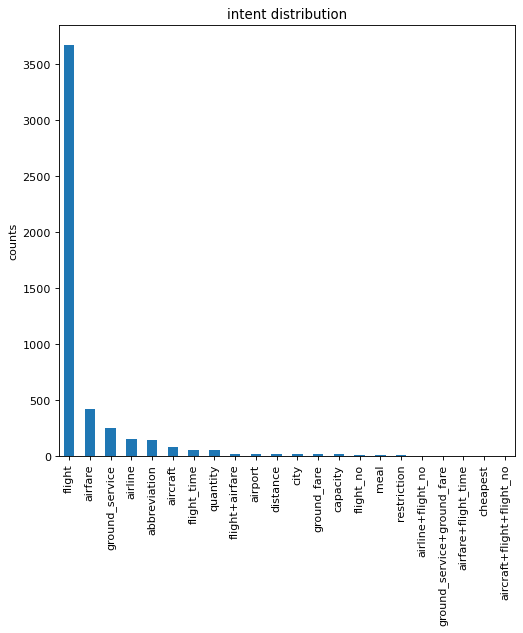

In [6]:
plotPerColumnDistribution(df, 10, 5)

We see that there is a major class imbalance, with a significantly higher number of intents being classified as flight related. There are 22 intent classes.

There are 4978 samples total.

#### Slots
Now take a look at some slot categories, which are parsed from the query, identified, and used for understanding the query

In [7]:
i2s_train_values = list(i2s_train.values())
df3 = pd.DataFrame()
for i in range(7):
    df3[str(i)] = i2s_train_values[i*15:(i+1)*15]
df3

,0,1,2,3,4,5,6
0,B-aircraft_code,B-arrive_time.time_relative,B-depart_date.year,B-flight_time,B-return_date.day_name,B-today_relative,I-arrive_time.time_relative
1,B-airline_code,B-booking_class,B-depart_time.end_time,B-fromloc.airport_code,B-return_date.day_number,B-toloc.airport_code,I-city_name
2,B-airline_name,B-city_name,B-depart_time.period_mod,B-fromloc.airport_name,B-return_date.month_name,B-toloc.airport_name,I-class_type
3,B-airport_code,B-class_type,B-depart_time.period_of_day,B-fromloc.city_name,B-return_date.today_relative,B-toloc.city_name,I-cost_relative
4,B-airport_name,B-compartment,B-depart_time.start_time,B-fromloc.state_code,B-return_time.period_mod,B-toloc.country_name,I-depart_date.day_name
5,B-arrive_date.date_relative,B-connect,B-depart_time.time,B-fromloc.state_name,B-return_time.period_of_day,B-toloc.state_code,I-depart_date.day_number
6,B-arrive_date.day_name,B-cost_relative,B-depart_time.time_relative,B-meal,B-round_trip,B-toloc.state_name,I-depart_date.today_relative
7,B-arrive_date.day_number,B-day_name,B-economy,B-meal_code,B-state_code,B-transport_type,I-depart_time.end_time
8,B-arrive_date.month_name,B-day_number,B-fare_amount,B-meal_description,B-state_name,I-airline_name,I-depart_time.period_of_day
9,B-arrive_date.today_relative,B-days_code,B-fare_basis_code,B-mod,B-stoploc.airport_code,I-airport_name,I-depart_time.start_time


## LSTM Model

This article implements a simple LSTM model to do intent classification on this ATIS dataset. https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03. I tried pretty hard to recreate this code, but I couldn't figure out how to resolve some layer shape incompatibility issues when creating the LSTM. Instead, I will summarize the results from the article and use it as a baseline to see if BERT can improve upon it.

As a side note, I learned a bit about input and output shapes in LSTM and would definitely be interested in solving this issue in the future. I suspect it has something to do with my datashape and the LSTM layer. https://shiva-verma.medium.com/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e

### LSTM Training

In [ ]:
# THIS CODE CELL DOES NOT RUN, IT JUST EXISTS TO SHOW THE LSTM RECURRENT NETWORK CREATED IN THE ARTICLE
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=len_input_train))
model_lstm.add(LSTM(units))
model_lstm.add(Dense(nb_labels, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

history_lstm = model_lstm.fit(input_data_train, intent_data_label_cat_train, 
                              epochs=10,batch_size=BATCH_SIZE)

![LSTM Training Accuracy](LSTM-trainingacc.png)
From the output, it can be seen that the Adam optimizer is stuck in a local minima because the loss and accuracy do not improve. The "flight" class has 3666 samples in it and there are 4978 queries total. $\frac{3666}{4978}\approx 73.64\%$ which corresponds with the training accuracy of the model. Without even looking at the outputs, it's a very reasonable guess that the model is predicting the majority class of 'flight' at every step.

### LSTM Model Evaluation
![LSTM Confusion Matrix](LSTM-confusionM.png)
The outputted confusion matrix shows that the model is clearly overfitting to the majority class.



### Model simplification
Next, the authors of the article simplify the classification task by making it a binary classification task where flight queries are one class and all other queries are another class. A similar network architecture is used, but with a sigmoid activation function in the Dense layer instead of a softmax and binary_crossentropy as the loss. Again, the model overfits, but always predicting the minority "Other" class this time.

I am interested to see how the BERT model performs against the LSTM for this intent classification task. I'm thinking it'll do much better.

### Comments for the Future
I would definitely like to work with imbalanced data more in the future to get more practice dealing with the challenges that come with it, especially because unbalanced datasets are so common. Maybe one of the future biweekly reports.